### import libraries

In [4]:
# COPD Severity Classification Pipeline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from scipy import stats
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [5]:
# Load dataset
print("\nLoading dataset...")
df = pd.read_csv('https://raw.githubusercontent.com/dgoyal607/copd/main/dataset.csv')


Loading dataset...


In [6]:
# Initial data exploration
df.head()

,Unnamed: 0,ID,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,...,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
0,1,58,77,60.0,SEVERE,120.0,120.0,120.0,1.21,36.0,...,69.55,4,3,1,2,1,0,0,1,0
1,2,57,79,50.0,MODERATE,165.0,176.0,176.0,1.09,56.0,...,44.24,4,2,0,2,1,0,0,1,1
2,3,62,80,11.0,MODERATE,201.0,180.0,201.0,1.52,68.0,...,44.09,4,2,0,2,1,0,0,1,0
3,4,145,56,60.0,VERY SEVERE,210.0,210.0,210.0,0.47,14.0,...,62.04,1,4,1,2,0,0,1,1,0
4,5,136,65,68.0,SEVERE,204.0,210.0,210.0,1.07,42.0,...,75.56,1,3,1,2,0,1,1,0,0


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    101 non-null    int64  
 1   ID            101 non-null    int64  
 2   AGE           101 non-null    int64  
 3   PackHistory   101 non-null    float64
 4   COPDSEVERITY  101 non-null    object 
 5   MWT1          99 non-null     float64
 6   MWT2          100 non-null    float64
 7   MWT1Best      100 non-null    float64
 8   FEV1          101 non-null    float64
 9   FEV1PRED      101 non-null    float64
 10  FVC           101 non-null    float64
 11  FVCPRED       101 non-null    int64  
 12  CAT           101 non-null    int64  
 13  HAD           101 non-null    float64
 14  SGRQ          101 non-null    float64
 15  AGEquartiles  101 non-null    int64  
 16  copd          101 non-null    int64  
 17  gender        101 non-null    int64  
 18  smoking       101 non-null    

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,101.0,51.000000,29.300171,1.00,26.00,51.00,76.00,101.00
ID,101.0,91.405941,51.516246,1.00,49.00,87.00,143.00,169.00
AGE,101.0,70.099010,7.898740,44.00,65.00,71.00,75.00,88.00
PackHistory,101.0,39.698020,24.558713,1.00,20.00,36.00,54.00,109.00
MWT1,99.0,385.858586,104.744199,120.00,300.00,419.00,460.50,688.00
MWT2,100.0,390.280000,107.754498,120.00,303.75,399.00,459.00,699.00
MWT1Best,100.0,399.110000,106.550116,120.00,303.75,420.00,465.25,699.00
FEV1,101.0,1.603762,0.672763,0.45,1.10,1.60,1.96,3.18
FEV1PRED,101.0,58.531485,22.294821,3.29,42.00,60.00,75.00,102.00
FVC,101.0,2.954950,0.976283,1.14,2.27,2.77,3.63,5.37


In [9]:
print(df.isnull().sum())

Unnamed: 0      0
ID              0
AGE             0
PackHistory     0
COPDSEVERITY    0
MWT1            2
MWT2            1
MWT1Best        1
FEV1            0
FEV1PRED        0
FVC             0
FVCPRED         0
CAT             0
HAD             0
SGRQ            0
AGEquartiles    0
copd            0
gender          0
smoking         0
Diabetes        0
muscular        0
hypertension    0
AtrialFib       0
IHD             0
dtype: int64


In [10]:
# Feature Engineering

df['FEV1_FVC_ratio'] = df['FEV1'] / (df['FVC'] + 1e-5)
df['MWT_Trend'] = df['MWT2'] - df['MWT1']
df['Age_Smoking_Risk'] = df['AGE'] * df['smoking']
df['Comorbidity_Score'] = df[['Diabetes', 'muscular', 'hypertension', 'AtrialFib', 'IHD']].sum(axis=1)

df['Lung_Function_Index'] = df['FEV1'] * df['FVC']  # Interaction for lung capacity
df['Symptom_Burden'] = df['CAT'] + df['HAD']  # Combined symptom score
df['PackHistory_Adjusted'] = df['PackHistory'] / (df['AGE'] + 1e-5)  # Smoking intensity per age

In [11]:
# Encode target variable
severity_map = {"MILD": 0, "MODERATE": 1, "SEVERE": 2, "VERY SEVERE": 3}
df['Severity'] = df['COPDSEVERITY'].map(severity_map)

In [12]:
# Drop the original COPDSEVERITY to prevent any potential leakage
df.drop('COPDSEVERITY', axis=1, inplace=True)

In [13]:
# Drop rows where target is NaN (if any)
df = df.dropna(subset=['Severity'])

In [14]:
# Impute missing values
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.difference(['Severity'])
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

In [15]:
# Outlier removal using IQR
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[col] = df[col].clip(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

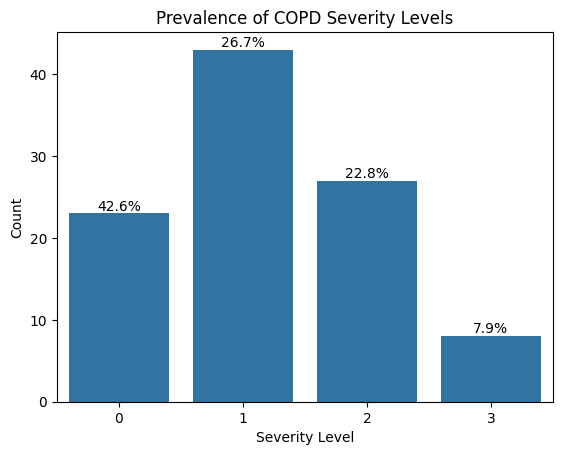

In [16]:
# EDA Visualizations

# 1. Severity distribution with business insight: Prevalence of each severity level
sns.countplot(x='Severity', data=df)
plt.title('Prevalence of COPD Severity Levels')
totals = df['Severity'].value_counts(normalize=True) * 100
for i, p in enumerate(plt.gca().patches):
    plt.gca().annotate(f'{totals.iloc[i]:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.show()

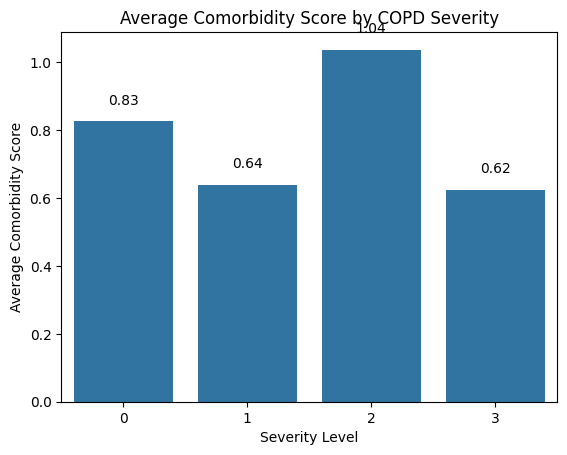

In [17]:
# 2. Average Comorbidity Score by Severity: Insight into health burden and potential care costs
avg_comorb = df.groupby('Severity')['Comorbidity_Score'].mean().reset_index()
sns.barplot(x='Severity', y='Comorbidity_Score', data=avg_comorb)
plt.title('Average Comorbidity Score by COPD Severity')
plt.xlabel('Severity Level')
plt.ylabel('Average Comorbidity Score')
for i, v in enumerate(avg_comorb['Comorbidity_Score']):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center')
plt.show()

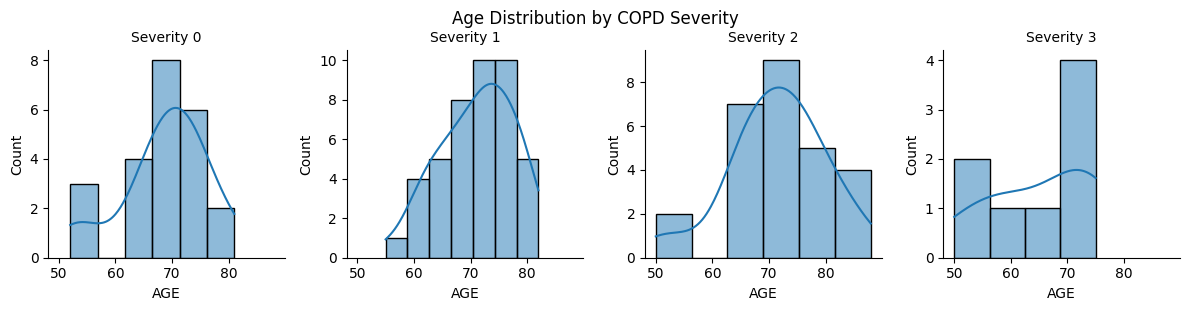

In [18]:
# 3. Age Distribution by Severity: Insight into age-related risk profiles
g = sns.FacetGrid(df, col='Severity', col_wrap=4, sharey=False)
g.map_dataframe(sns.histplot, x='AGE', kde=True)
g.set_titles('Severity {col_name}')
g.fig.suptitle('Age Distribution by COPD Severity', y=1.02)
plt.show()

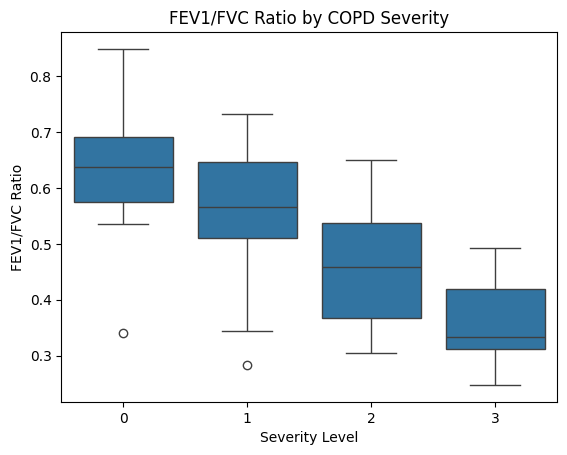

In [19]:
# 4. Lung Function (FEV1/FVC Ratio) vs Severity: Key diagnostic insight
sns.boxplot(x='Severity', y='FEV1_FVC_ratio', data=df)
plt.title('FEV1/FVC Ratio by COPD Severity')
plt.xlabel('Severity Level')
plt.ylabel('FEV1/FVC Ratio')
plt.show()

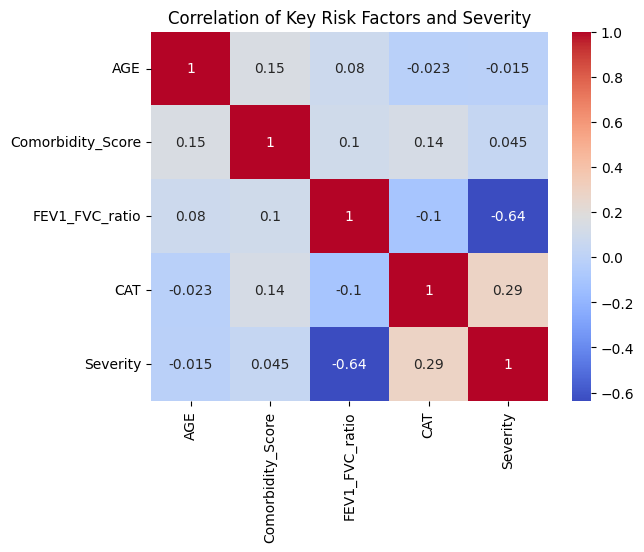

In [20]:
# 5. Correlation Heatmap of Key Risk Factors: Insight into interrelated risks
key_risk_cols = ['AGE', 'Comorbidity_Score', 'FEV1_FVC_ratio', 'CAT', 'Severity']
corr = df[key_risk_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation of Key Risk Factors and Severity')
plt.show()

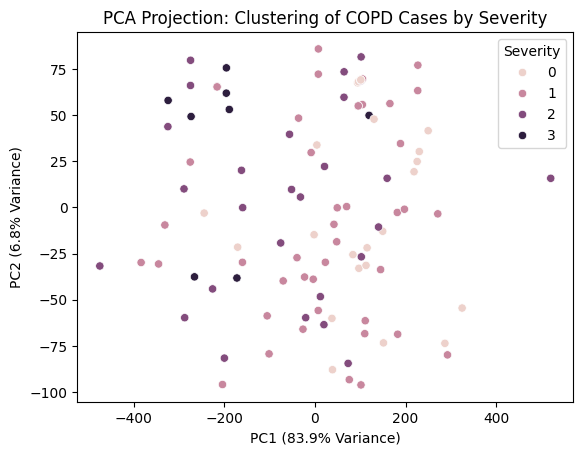

In [21]:
# 7. PCA for Dimensionality Insight: Overview of feature variance explained
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.difference(['Severity'])
pca = PCA(n_components=2)
pca_feats = pca.fit_transform(df[num_cols])
pca_df = pd.DataFrame(data=pca_feats, columns=['PC1', 'PC2'])
pca_df['Severity'] = df['Severity'].values
sns.scatterplot(x='PC1', y='PC2', hue='Severity', data=pca_df)
plt.title('PCA Projection: Clustering of COPD Cases by Severity')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} Variance)')
plt.show()

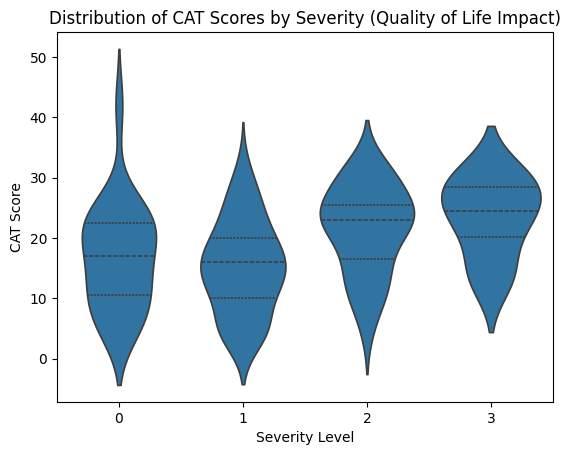

In [22]:
# 8. CAT Score Trends: Insight into quality of life impact
sns.violinplot(x='Severity', y='CAT', data=df, inner='quartile')
plt.title('Distribution of CAT Scores by Severity (Quality of Life Impact)')
plt.xlabel('Severity Level')
plt.ylabel('CAT Score')
plt.show()

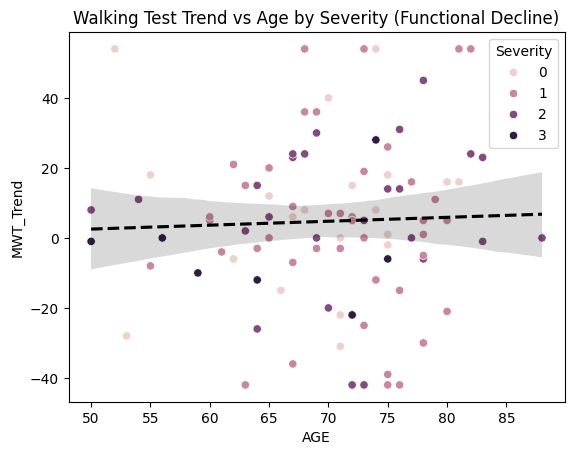

In [23]:
# 9. MWT Trend by Age and Severity: Insight into functional decline
sns.scatterplot(x='AGE', y='MWT_Trend', hue='Severity', data=df)
sns.regplot(x='AGE', y='MWT_Trend', data=df, scatter=False, color='black', line_kws={'linestyle':'--'})
plt.title('Walking Test Trend vs Age by Severity (Functional Decline)')
plt.show()

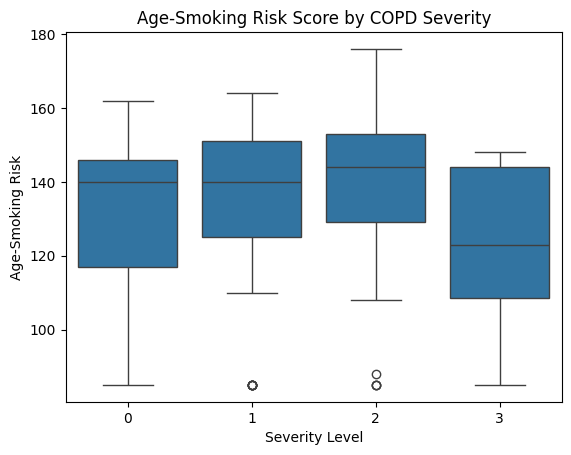

In [24]:
# 10. Boxplot of Age-Smoking Risk by Severity: Insight into compounded risk factors
sns.boxplot(x='Severity', y='Age_Smoking_Risk', data=df)
plt.title('Age-Smoking Risk Score by COPD Severity')
plt.xlabel('Severity Level')
plt.ylabel('Age-Smoking Risk')
plt.show()

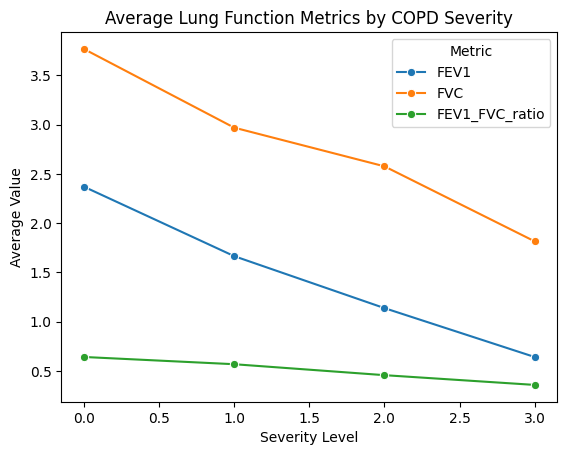

In [25]:
# 11. Line Plot of Average Lung Function Metrics by Severity: Insight into progression
lung_metrics = df.groupby('Severity')[['FEV1', 'FVC', 'FEV1_FVC_ratio']].mean().reset_index()
lung_metrics_melt = lung_metrics.melt(id_vars='Severity', value_vars=['FEV1', 'FVC', 'FEV1_FVC_ratio'])
sns.lineplot(x='Severity', y='value', hue='variable', data=lung_metrics_melt, marker='o')
plt.title('Average Lung Function Metrics by COPD Severity')
plt.xlabel('Severity Level')
plt.ylabel('Average Value')
plt.legend(title='Metric')
plt.show()

In [26]:
# Drop constant columns after EDA (to avoid issues in VIF and modeling)
constant_cols = [col for col in num_cols if df[col].nunique() <= 1]
df.drop(columns=constant_cols, inplace=True)
print(f"Dropped constant columns: {constant_cols}")

Dropped constant columns: ['AtrialFib', 'Diabetes', 'IHD', 'hypertension', 'muscular', 'smoking']


In [27]:
# Multicollinearity check
print("\nCalculating VIF to detect multicollinearity...")
numeric_cols = df.select_dtypes(include=[np.number]).columns.difference(['Severity'])
X_vif = df[numeric_cols].copy()
X_vif = StandardScaler().fit_transform(X_vif.fillna(0))
vif = pd.DataFrame({
    'feature': numeric_cols,
    'VIF': [variance_inflation_factor(X_vif, i) for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)
print(vif)


Calculating VIF to detect multicollinearity...
                 feature         VIF
13                  MWT1  169.544989
5                   FEV1  156.905167
14              MWT1Best  134.034533
15                  MWT2  127.693187
20        Symptom_Burden  122.319540
18  PackHistory_Adjusted   81.075040
12   Lung_Function_Index   80.357468
17           PackHistory   78.441173
3                    CAT   57.604016
10                   HAD   38.293930
8                    FVC   32.626786
7         FEV1_FVC_ratio   24.940586
21            Unnamed: 0   14.309849
0                    AGE   11.948775
16             MWT_Trend   10.603936
1           AGEquartiles    7.485564
6               FEV1PRED    6.688804
22                  copd    6.635295
9                FVCPRED    5.834190
19                  SGRQ    3.543559
23                gender    3.060099
2       Age_Smoking_Risk    2.200815
4      Comorbidity_Score    1.644262
11                    ID    1.469046


In [28]:
# Drop multicollinear columns (VIF > 5, but retain more by using PCA on high VIF features)
high_vif = vif[vif['VIF'] > 5]['feature'].tolist()
print(f"High VIF features: {high_vif}")

High VIF features: ['MWT1', 'FEV1', 'MWT1Best', 'MWT2', 'Symptom_Burden', 'PackHistory_Adjusted', 'Lung_Function_Index', 'PackHistory', 'CAT', 'HAD', 'FVC', 'FEV1_FVC_ratio', 'Unnamed: 0', 'AGE', 'MWT_Trend', 'AGEquartiles', 'FEV1PRED', 'copd', 'FVCPRED']


In [29]:
# Apply PCA to high VIF features to reduce dimensionality while retaining info
if high_vif:
    pca_high = PCA(n_components=min(3, len(high_vif)))
    pca_transformed = pca_high.fit_transform(df[high_vif])
    for i in range(pca_transformed.shape[1]):
        df[f'PCA_{i}'] = pca_transformed[:, i]
    df.drop(columns=high_vif, inplace=True)

In [30]:
# Feature selection based on correlation (excluding Severity to prevent leak)
numeric_df = df.select_dtypes(include=[np.number]).drop('Severity', axis=1, errors='ignore')
corr_numeric = numeric_df.corrwith(df['Severity']).abs().sort_values(ascending=False)
top_feats = corr_numeric[:15].index.tolist()
ndf = df[top_feats + ['Severity']]

In [31]:
ndf.head()

,PCA_2,PCA_0,SGRQ,PCA_1,ID,gender,Comorbidity_Score,Age_Smoking_Risk,Severity
0,19.816775,-473.542113,69.55,11.637687,58.0,1.0,2.0,154.0,2
1,-0.660991,-383.555732,44.24,18.413771,57.0,0.0,2.5,158.0,1
2,15.395213,-344.934093,44.09,-10.864878,62.0,0.0,2.0,160.0,1
3,-48.495099,-323.832611,62.04,-19.138627,145.0,1.0,2.0,112.0,3
4,16.195154,-323.368768,75.56,10.001195,136.0,1.0,2.0,130.0,2


In [32]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(ndf.drop('Severity', axis=1), ndf['Severity'])

In [33]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

In [34]:
# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression with reduced GridSearch
print("\nTraining Logistic Regression with tuning...")
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=1000))])
lr_params = {'lr__C': [0.1, 1], 'lr__solver': ['lbfgs', 'liblinear']}
lr_grid = GridSearchCV(lr_pipe, lr_params, cv=cv, scoring='f1_macro')
lr_grid.fit(X_train, y_train)
y_lr = lr_grid.predict(X_test)
acc_lr = accuracy_score(y_test, y_lr)
prec_lr = precision_score(y_test, y_lr, average='macro')
rec_lr = recall_score(y_test, y_lr, average='macro')
f1_lr = f1_score(y_test, y_lr, average='macro')
auc_lr = roc_auc_score(y_test, lr_grid.predict_proba(X_test), multi_class='ovr')
print(classification_report(y_test, y_lr))
print(f"LR Best Params: {lr_grid.best_params_}")
print(f"LR Accuracy: {acc_lr:.3f}, Precision: {prec_lr:.3f}, Recall: {rec_lr:.3f}, F1: {f1_lr:.3f}, AUC: {auc_lr:.3f}")


Training Logistic Regression with tuning...
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       0.71      0.62      0.67         8
           2       0.67      0.67      0.67         9
           3       0.88      0.78      0.82         9

    accuracy                           0.77        35
   macro avg       0.77      0.77      0.76        35
weighted avg       0.77      0.77      0.77        35

LR Best Params: {'lr__C': 1, 'lr__solver': 'lbfgs'}
LR Accuracy: 0.771, Precision: 0.769, Recall: 0.767, F1: 0.764, AUC: 0.937


In [35]:
# Random Forest with reduced GridSearch
print("\nTraining Random Forest with tuning...")
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))])
rf_params = {'rf__n_estimators': [100, 200], 'rf__max_depth': [None, 20], 'rf__min_samples_split': [2, 5]}
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=cv, scoring='f1_macro')
rf_grid.fit(X_train, y_train)
y_rf = rf_grid.predict(X_test)
acc_rf = accuracy_score(y_test, y_rf)
prec_rf = precision_score(y_test, y_rf, average='macro')
rec_rf = recall_score(y_test, y_rf, average='macro')
f1_rf = f1_score(y_test, y_rf, average='macro')
auc_rf = roc_auc_score(y_test, rf_grid.predict_proba(X_test), multi_class='ovr')
print(classification_report(y_test, y_rf))
print(f"RF Best Params: {rf_grid.best_params_}")
print(f"RF Accuracy: {acc_rf:.3f}, Precision: {prec_rf:.3f}, Recall: {rec_rf:.3f}, F1: {f1_rf:.3f}, AUC: {auc_rf:.3f}")


Training Random Forest with tuning...
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.86      0.75      0.80         8
           2       0.88      0.78      0.82         9
           3       0.90      1.00      0.95         9

    accuracy                           0.89        35
   macro avg       0.88      0.88      0.88        35
weighted avg       0.88      0.89      0.88        35

RF Best Params: {'rf__max_depth': None, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
RF Accuracy: 0.886, Precision: 0.883, Recall: 0.882, F1: 0.880, AUC: 0.957


In [36]:
# Hybrid Model: Random Forest for feature extraction + XGBoost for classification
print("\nTraining Hybrid RF + XGBoost...")
# Use RF to extract important features
rf_extractor = rf_grid.best_estimator_.named_steps['rf']
feature_importances = pd.Series(rf_extractor.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_hybrid_feats = feature_importances.head(10).index.tolist()  # Select top 10 important features

# Train XGBoost on selected features
xgb_pipe = Pipeline([('scaler', StandardScaler()), ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))])
xgb_params = {'xgb__n_estimators': [100, 200], 'xgb__learning_rate': [0.05, 0.1], 'xgb__max_depth': [3, 5]}
xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=cv, scoring='f1_macro')
xgb_grid.fit(X_train[top_hybrid_feats], y_train)
y_hybrid = xgb_grid.predict(X_test[top_hybrid_feats])
acc_hybrid = accuracy_score(y_test, y_hybrid)
prec_hybrid = precision_score(y_test, y_hybrid, average='macro')
rec_hybrid = recall_score(y_test, y_hybrid, average='macro')
f1_hybrid = f1_score(y_test, y_hybrid, average='macro')
auc_hybrid = roc_auc_score(y_test, xgb_grid.predict_proba(X_test[top_hybrid_feats]), multi_class='ovr')
print(classification_report(y_test, y_hybrid))
print(f"Hybrid Best Params: {xgb_grid.best_params_}")
print(f"Hybrid Accuracy: {acc_hybrid:.3f}, Precision: {prec_hybrid:.3f}, Recall: {rec_hybrid:.3f}, F1: {f1_hybrid:.3f}, AUC: {auc_hybrid:.3f}")


Training Hybrid RF + XGBoost...
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       0.83      0.62      0.71         8
           2       0.88      0.78      0.82         9
           3       0.90      1.00      0.95         9

    accuracy                           0.86        35
   macro avg       0.86      0.85      0.85        35
weighted avg       0.86      0.86      0.85        35

Hybrid Best Params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}
Hybrid Accuracy: 0.857, Precision: 0.857, Recall: 0.851, F1: 0.846, AUC: 0.947


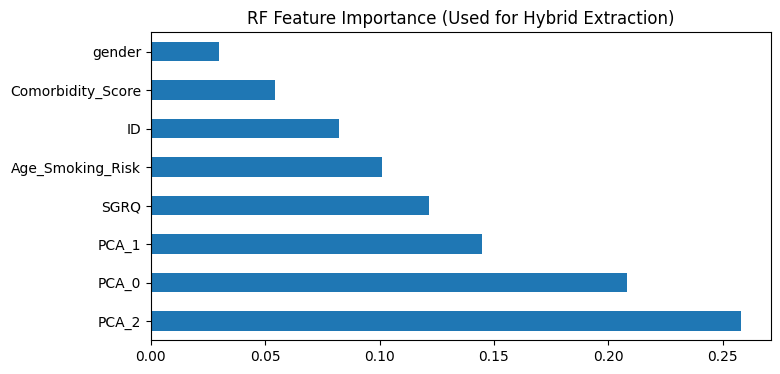

In [37]:
# Feature importance from RF (used for extraction)
df_imp = feature_importances.sort_values(ascending=False)
plt.figure(figsize=(8,4))
df_imp.plot(kind='barh')
plt.title('RF Feature Importance (Used for Hybrid Extraction)')
plt.show()

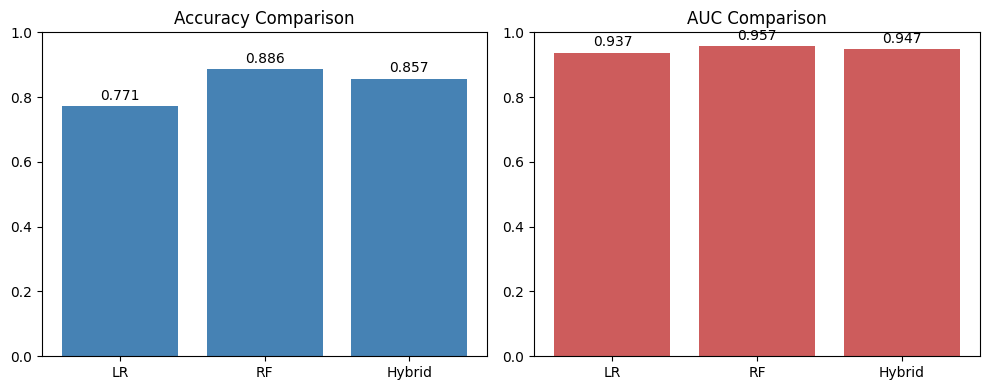

In [38]:
# Score comparison plot
models = ['LR', 'RF', 'Hybrid']
accs = [acc_lr, acc_rf, acc_hybrid]
aucs = [auc_lr, auc_rf, auc_hybrid]
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].bar(models, accs, color='steelblue')
axs[0].set_title('Accuracy Comparison')
axs[1].bar(models, aucs, color='indianred')
axs[1].set_title('AUC Comparison')
for ax in axs:
    ax.set_ylim(0, 1)
    for i, v in enumerate(accs if ax == axs[0] else aucs):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center')
plt.tight_layout()
plt.show()